In [ ]:
# 야생동물 데이터 다운로드
# https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=645

In [ ]:
import json
import shutil
import os 
import yaml
import cv2
import zipfile
import time
from glob import glob
from tqdm import tqdm
from openpyxl import Workbook
from scipy.sparse import data
from sklearn.model_selection import train_test_split

In [ ]:

# 종혁 : 코랩 실행시
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 압축 파일 경로를 설정해주세요.
# 리스트 형태이며, 여러 파일도 가능합니다.
zip_file_path_image = ['/content/drive/MyDrive/[SeSAC] Final_PJT 공유폴더/03. 파이널_야생동물 객체 탐지, 추적 모델/데이터셋/1.Training/원천데이터/TS_01.고라니.zip']
                      #  '/content/drive/MyDrive/[SeSAC] Final_PJT 공유폴더/03. 파이널_야생동물 객체 탐지, 추적 모델/데이터셋/1.Training/원천데이터/TS_02.멧돼지.zip',
                      #  '/content/drive/MyDrive/[SeSAC] Final_PJT 공유폴더/03. 파이널_야생동물 객체 탐지, 추적 모델/데이터셋/1.Training/원천데이터/TS_03.너구리.zip',
                      #  '/content/drive/MyDrive/[SeSAC] Final_PJT 공유폴더/03. 파이널_야생동물 객체 탐지, 추적 모델/데이터셋/1.Training/원천데이터/TS_06.반달가슴곰.zip',
                      #  '/content/drive/MyDrive/[SeSAC] Final_PJT 공유폴더/03. 파이널_야생동물 객체 탐지, 추적 모델/데이터셋/1.Training/원천데이터/TS_07.족제비.zip',
                      #  '/content/drive/MyDrive/[SeSAC] Final_PJT 공유폴더/03. 파이널_야생동물 객체 탐지, 추적 모델/데이터셋/1.Training/원천데이터/TS_09.왜가리.zip',
                      #  '/content/drive/MyDrive/[SeSAC] Final_PJT 공유폴더/03. 파이널_야생동물 객체 탐지, 추적 모델/데이터셋/1.Training/원천데이터/TS_10.중대백로.zip',]

zip_file_path_json = ['/content/drive/MyDrive/[SeSAC] Final_PJT 공유폴더/03. 파이널_야생동물 객체 탐지, 추적 모델/데이터셋/1.Training/라벨링데이터/TL_01.고라니.zip']
                      # '/content/drive/MyDrive/[SeSAC] Final_PJT 공유폴더/03. 파이널_야생동물 객체 탐지, 추적 모델/데이터셋/1.Training/라벨링데이터/TL_02.멧돼지.zip',
                      # '/content/drive/MyDrive/[SeSAC] Final_PJT 공유폴더/03. 파이널_야생동물 객체 탐지, 추적 모델/데이터셋/1.Training/라벨링데이터/TL_03.너구리.zip',
                      # '/content/drive/MyDrive/[SeSAC] Final_PJT 공유폴더/03. 파이널_야생동물 객체 탐지, 추적 모델/데이터셋/1.Training/라벨링데이터/TL_06.반달가슴곰.zip',
                      # '/content/drive/MyDrive/[SeSAC] Final_PJT 공유폴더/03. 파이널_야생동물 객체 탐지, 추적 모델/데이터셋/1.Training/라벨링데이터/TL_07.족제비.zip',
                      # '/content/drive/MyDrive/[SeSAC] Final_PJT 공유폴더/03. 파이널_야생동물 객체 탐지, 추적 모델/데이터셋/1.Training/라벨링데이터/TL_09.왜가리.zip',
                      # '/content/drive/MyDrive/[SeSAC] Final_PJT 공유폴더/03. 파이널_야생동물 객체 탐지, 추적 모델/데이터셋/1.Training/라벨링데이터/TL_10.중대백로.zip',]

# 본 Main 코드 폴더가 있는 폴더 경로를 지정해주세요.
# 압축이 풀린"이미지" 파일은 Main 코드가 있는 폴더 -> Dataset -> images 폴더로 들어갑니다.
# 압축이 풀린"json" 파일은 Main 코드가 있는 폴더 -> Dataset -> json 폴더로 들어갑니다.

!mkdir /content/train
!mkdir /content/train/Dataset
!mkdir /content/train/Dataset/images
!mkdir /content/train/Dataset/json
!mkdir /content/train/Dataset/labels

main_path = '/content/train/'
google_drive_path = '/content/drive/MyDrive/[SeSAC] Final_PJT 공유폴더/03. 파이널_야생동물 객체 탐지, 추적 모델/코드/01. 객체 인지 모델 (야생동물)/'

In [ ]:
# 압축 해제

for i in tqdm(range(len(zip_file_path_image))):
  zip_file_image = zipfile.ZipFile(zip_file_path_image[i])
  file_list = zip_file_image.namelist()
  for file_name in tqdm(file_list, desc=f'Extracting files ({i+1}/{2*len(zip_file_path_image)}'):
    zip_file_image.extract(file_name, main_path + 'Dataset/images')

  zip_file_json = zipfile.ZipFile(zip_file_path_json[i])
  file_list = zip_file_json.namelist()
  for file_name in tqdm(file_list, desc = f'Extracting files ({i+1}/{2*len(zip_file_path_image)}'):
    zip_file_json.extract(file_name, main_path + 'Dataset/json')

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Extracting files (1/14: 100%|██████████| 31074/31074 [05:09<00:00, 100.43it/s]

Extracting files (2/14: 100%|██████████| 30700/30700 [04:13<00:00, 121.02it/s]

Extracting files (3/14: 100%|██████████| 13743/13743 [01:35<00:00, 144.49it/s]

Extracting files (4/14: 100%|██████████| 14960/14960 [02:10<00:00, 114.73it/s]

Extracting files (5/14: 100%|██████████| 14857/14857 [01:47<00:00, 137.65it/s]

Extracting files (6/14: 100%|██████████| 25974/25974 [02:47<00:00, 155.43it/s]

Extracting files (7/14: 100%|██████████| 21587/21587 [02:25<00:00, 148.20it/s]

100%|██████████| 7/7 [20:54<00:00, 179.25s/it]


> **데이터 전처리**  

(1) json 파일 -> txt 파일로 convert : 동물 종 이름, bounding box 혹은 segmentation의 좌표  
(2) 이미지 리사이징 : 416 x 416 사이즈  
(3) Train - Val - Test split  

In [ ]:

# json 형태의 annotation 데이터를 YOLOv5 학습 형태에 맞게 txt 로 변환한다.
# 변환된 데이터는 ./Dataset/labels 에 저장됩니다.

classification = []
count = []

TOP = 0
LEFT = 1
BOTTOM = 2
RIGHT = 3

SQURE = 1

class Label:

	def __init__(self, fileName, imagePath):
		data = self.parse_json_data(fileName)
		self.set_data(data, fileName, imagePath)

	def parse_json_data(self, fileName):
		with open(fileName, encoding='utf-8-sig') as jsonFile:
			jsonData = json.load(jsonFile)
		return jsonData

	def set_data(self, data, fileName, imagePath):
		self.fileName = '.'.join(os.path.basename(fileName).split('.')[0:-1])
		self.width = int(data['images'][0]['width'])
		self.height = int(data['images'][0]['height'])
		self.annotations = data['annotations']

	def get_bbox_point(self, bbox):
		top = 10000
		left = 10000
		bottom = -1
		right = -1

		for i in bbox:
			if (i[0] < left): left = i[0]
			if (i[0] > right): right = i[0]
			if (i[1] < top): top = i[1]
			if (i[1] > bottom): bottom = i[1]

		return ((top, left, bottom, right))

	def get_segment_point(self, seg):
		top = 10000
		left = 10000
		bottom = -1
		right = -1

		for i in range(len(seg)):
			if (i % 2 == 0):
				if (seg[i] < left): left = seg[i]
				if (seg[i] > right): right = seg[i]
			else:
				if (seg[i] < top): top = seg[i]
				if (seg[i] > bottom): bottom = seg[i]

		return ((top, left, bottom, right))

	def get_shape_point(self, shape):
		try: #종혁 : 추가
			if (shape['bbox'] and len(shape['bbox']) != 0):
				return self.get_bbox_point(shape['bbox'])
			elif (shape['Segmentation'] and len(shape['Segmentation']) != 0):
				return self.get_segment_point(shape['Segmentation'][0])
			else:
				return (0, 0, 0, 0)
		except: #종혁 : 추가
			return (0, 0, 0, 0) #종혁 : 추가

	def point_to_txt(self, point):
		if (point[0]) not in classification:
			classification.append(point[0])
			count.append(0)
		idx = classification.index(point[0])
		count[idx] += 1

		if (SQURE):
			r = (self.width - self.height) / 2
			w_center = ((point[1][LEFT] + point[1][RIGHT]) / 2) / self.width
			h_center = (((point[1][TOP] + point[1][BOTTOM]) / 2) + r) / self.width
			w_len = (point[1][RIGHT] - point[1][LEFT]) / self.width
			h_len = (point[1][BOTTOM] - point[1][TOP]) / self.width
		else:
			w_center = ((point[1][LEFT] + point[1][RIGHT]) / 2) / self.width
			h_center = ((point[1][TOP] + point[1][BOTTOM]) / 2) / self.height
			w_len = (point[1][RIGHT] - point[1][LEFT]) / self.width
			h_len = (point[1][BOTTOM] - point[1][TOP]) / self.height
		return (idx, w_center, h_center, w_len, h_len)

	def convert_data(self):
		self.points = []
		self.txt = []
		for shape in self.annotations:
			self.points.append((shape['species'], self.get_shape_point(shape)))
		for point in self.points:
			self.txt.append(self.point_to_txt(point))

	def write_data(self, path):
		with open(path + self.fileName + ".txt", 'w') as f:
			for line in self.txt:
				f.write(' '.join(map(str, line)) + "\n")

def convert_data(file, targetPath, imagePath):
	target = Label(file, imagePath)
	target.convert_data()
	target.write_data(targetPath)

json_count = [0]
def convert(targetPath, src):
    from tqdm import tqdm
    
    path = src + '/json'
    data_list = os.listdir(path)
    json_count = [0]
    
    for line in tqdm(data_list):
        json_count[0] += 1
        convert_data(path + '/' + line, src + '/labels/', src + '/images/')
        
    

image_count = [0]
def copy_image(targetPath, src):
	data_list = os.listdir(targetPath)
	for line in data_list:
		if os.path.isdir(os.path.join(targetPath, line)):
			copy_image(os.path.join(targetPath, line), src)
		elif '.jpg' in line:
			image_count[0] += 1
			print(image_count[0], "Image Copy:", line, end='\r')
			shutil.copyfile(targetPath + "/" + line, src + "/images/" + line)
		else:
			pass

def write_yaml(target):
	data = {}
	data["names"] = classification
	data["nc"] = len(classification)
	data["train"] = "../Dataset/train.txt"
	data["val"] = "../Dataset/valid.txt"
	data["test"] = "../Dataset/test.txt"
	with open(target, 'w', encoding='utf-8-sig') as f:
		yaml.dump(data, f, allow_unicode=True)

def run_convert(targetPath, src, copy):
	if not os.path.isdir(src + "/images"):
		os.makedirs(src + "/images/")
	if not os.path.isdir(src + "/labels"):
		os.makedirs(src + "/labels")
	if not os.path.isdir(src + "/json"):
		os.makedirs(src + "/json")
	# if copy:
	# 	copy_image(targetPath, src)
	# 비효율적인 코드 삭제 ==> 대신 image 폴더에 직접 이미지 넣어야 함
	convert(targetPath, src)
	write_yaml(os.path.join(src, "data.yaml"))
	for i in range(len(classification)):
		print(classification[i], "is counted:", count[i])

# 코랩 실행시
## 종혁 : 경로 재설정, 소요시간 기록
## run_convert(,,False) : False = 복사를 하지 않음
main_path = main_path
run_convert("OriginData", main_path + "Dataset", False)
# 메인 코드 : 컨버팅


100%|██████████| 152895/152895 [01:18<00:00, 1936.57it/s]

족제비 is counted: 14861
멧돼지 is counted: 34485
너구리 is counted: 13870
고라니 is counted: 32256
반달가슴곰 is counted: 23769
노루 is counted: 773
중대백로 is counted: 24816
왜가리 is counted: 27711
멧토끼 is counted: 3
다람쥐 is counted: 1


In [ ]:
# 변환된 데이터셋에 있는 이미지를 학습에 맞게 정사각형으로 변환 및 416x416 사이즈로 변경한다.

IMG_SIZE = 416

def image_resize(target):
	img = cv2.imread(target)
	# print(target)
	h, w = img.shape[:2]

	color = 0
	if w > h:
		borderSize = int((w - h) / 2)
		border = cv2.copyMakeBorder(
			img,
			top=borderSize,
			bottom=borderSize,
			left=0,
			right=0,
			borderType=cv2.BORDER_CONSTANT,
			value=[color, color, color]
		)
	else:
		borderSize = int((h - w) / 2)
		border = cv2.copyMakeBorder(
			img,
			top=0,
			bottom=0,
			left=borderSize,
			right=borderSize,
			borderType=cv2.BORDER_CONSTANT,
			value=[color, color, color]
		)

	resize = cv2.resize(border, (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_CUBIC)
	cv2.imwrite(target, resize)

def resizing_img(targetPath):
	from tqdm import tqdm

	count = 0
	imgList = os.listdir(targetPath)
	imgList = [ (targetPath + '/' + x) for x in imgList if x.endswith('.jpg')]
	print(f'{len(imgList)}개 중')
	for img in tqdm(imgList):
		count+=1
		image_resize(img)

# 코랩 실행시
## 종혁 : 경로 재설정, 소요시간 기록
main_path = main_path
resizing_img(main_path + "Dataset/images")

152895개 중


100%|██████████| 152895/152895 [1:43:44<00:00, 24.57it/s]


In [ ]:
# 학습에 사용할 데이터셋을 Train:Valid:Test 로 구분하여 각 8:1:1 의 비율로 나눈다.
# 나눠진 데이터셋의 상세 내용은 count.xlsx 엑셀파일에 저장
# 에러가 있는 데이터는 err.txt 에 저장

pr = [0]

# animal = ["고라니", "멧돼지", "너구리 ", "다람쥐", "청설모", "반달가슴곰", "족제비", "멧토끼", "왜가리", "중대백로", "노루"]
animal = ["person", "멧돼지"]
obj_count = []
img_count = []
err_count = []

def get_json_data(fileName, trainList, validList, testList):

	with open(fileName, encoding='utf-8-sig') as jsonFile:
		jsonData = json.load(jsonFile)
	fName = ('.'.join(fileName.split('.')[0:-1]) + ".jpg").replace("/json/", "/images/")
	pr[0] += 1
	print('\r', pr, fName)

	day = str(jsonData['images'][0]['type'])
	if day != "RGB" and day != "IR":
		err_count.append(fName)
		return

	obj_list = jsonData['annotations']

	trainCount = 0
	validCount = 0
	testCount = 0

	for i in obj_count:
		if i[0] == ("train", obj_list[0]['species'], day):	trainCount += i[1]
		elif i[0] == ("valid", obj_list[0]['species'], day):	validCount += i[1]
		elif i[0] == ("test", obj_list[0]['species'], day):	testCount += i[1]

	if int(trainCount / 8) < validCount:
		data_type = "train"
		trainList.append(fName)
	elif validCount <= testCount:
		data_type = "valid"
		validList.append(fName)
	else:
		data_type = "test"
		testList.append(fName)

	for obj in obj_list:
		check = 0
		for i in obj_count:
			if i[0] == (data_type, obj['species'], day):
				i[1] += 1
				check = 1
				break
		if not check:
			obj_count.append([(data_type, obj['species'], day), 1])

	spec = animal[int(os.path.basename(fileName).split('_')[0][1:]) - 1]
	check = 0
	for j in img_count:
		if j[0] == (data_type, spec, day):
			j[1] += 1
			check = 1
			break
	if not check:
		img_count.append([(data_type, spec, day), 1])

def parse_data(targetPath, trainList, validList, testList):
	data_list = os.listdir(targetPath)
	for line in data_list:
		if os.path.isdir(os.path.join(targetPath, line)):
			parse_data(os.path.join(targetPath, line), trainList, validList, testList)
		elif '.json' in line:
			get_json_data(targetPath + "/" + line, trainList, validList, testList)
		else:
			pass

def print_data(writePath):
	obj_count.sort()
	img_count.sort()

	count = 0
	print("==========object count==========")
	for i in obj_count:
		print(f"{i[0][0]}: {i[0][1]}: {i[0][2]}: {i[1]} counted")
		count += i[1]
	print("count:",count)

	count = 0
	print("==========image count==========")
	for i in img_count:
		print(f"{i[0][0]}: {i[0][1]}: {i[0][2]}: {i[1]} counted")
		count += i[1]
	print("count:",count)

	print("==========err count==========")
	with open(writePath + "/err.txt", "w", encoding='utf-8-sig') as f:
		f.write("\n".join(err_count) + "\n")
	print("count:",len(err_count))

def print_excel(writePath):
	wb = Workbook()
	ws = wb.active
	ws.title = "count"
	ws.append(["Object"])
	ws.append(["data_type", "object_type", "day", "count"])
	for i in obj_count:
		ws.append(i[0] + (i[1],))

	ws.append(["Image"])
	ws.append(["data_type", "object_type", "day", "count"])
	for i in img_count:
		ws.append(i[0] + (i[1],))
	wb.save(writePath + "/count.xlsx")

def split_dataset(targetPath, writePath):

	targetPath = os.path.abspath(targetPath)
	train_list = []
	valid_list = []
	test_list = []
	parse_data(targetPath, train_list, valid_list, test_list)
    
	with open(writePath + "/train.txt", "w", encoding='utf-8-sig') as f:
		f.write("\n".join(train_list) + "\n")
	with open(writePath + "/valid.txt", "w", encoding='utf-8-sig') as f:
		f.write("\n".join(valid_list) + "\n")
	with open(writePath + "/test.txt", "w", encoding='utf-8-sig') as f:
		f.write("\n".join(test_list) + "\n")

	print("train data: ", len(train_list))
	print("valid data: ", len(valid_list))
	print("test data: ", len(test_list))
	print_data('\r'+ writePath)
	print_excel('\r'+ writePath)

	return test_list

# 로컬 실행시
# import time
# start = time.time()
# split_dataset("./Dataset/json", "./Dataset")
# end = time.time()
# print(f'{end - start:.5f} sec')


# 코랩 실행시
## 종혁 : 경로 재설정, 소요시간 기록
main_path = main_path
split_dataset(main_path + "Dataset/json", main_path + "Dataset")
# 메인코드 : train-val-test split
# 2.멧돼지 528초

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 [147989] /content/train/Dataset/images/A07_G11_G001_C_200421_5001_10S_000000.841.jpg
 [147990] /content/train/Dataset/images/A03_H20_C012_C_211123_1011_29S_000005.015.jpg
 [147991] /content/train/Dataset/images/A07_H20_C070_D_211206_6002_57S_000001.007.jpg
 [147992] /content/train/Dataset/images/A10_H03_C016_D_210918_0029_60S_000033.638.jpg
 [147993] /content/train/Dataset/images/A01_H29_C007_C_211121_3010_20S_000018.003.jpg
 [147994] /content/train/Dataset/images/A09_H05_C016_D_211005_0008_53S_000039.547.jpg
 [147995] /content/train/Dataset/images/A02_H17_C051_S_210909_0002_30S_000020.944.jpg
 [147996] /content/train/Dataset/images/A07_H20_C070_D_211206_6002_57S_000001.016.jpg
 [147997] /content/train/Dataset/images/A06_P08_C051_C_210930_0037_60S_000018.105.jpg
 [147998] /content/train/Dataset/images/A10_H20_C006_D_210928_0002_36S_000009.663.jpg
 [147999] /content/train/Dataset/images/A02_H17_C020_D_210909_0008_44S_000016.042.jpg
 [148000] /content

FileNotFoundError: ignored

> **여기까지 실행하면, Dataset 폴더에 파일들이 생성되어 있어야 합니다.**  
  
(1) Dataset - images 폴더 : 리사이징 된 이미지들    
(2) Dataset - json 폴더 : 바운딩박스 좌표 및 메타데이터  
(3) Dataset - labels 폴더 : 바운딩박스 좌표(txt)  
(4) Dataset - data.yaml 파일 : 학습 위한 이미지 - 라벨 매칭 데이터로 보임  
(5) Dataset - test.txt 파일 : split 된 테스트 파일에 대한 정보  
(6) Dataset - train.txt 파일 : split 된 트레인 파일에 대한 정보  
(7) Dataset - valid.txt 파일 : split 된 검증용 파일에 대한 정보  
(8) Dataset - err.txt 파일 : 전처리 중 에러가 발생한 파일에 대한 정보  

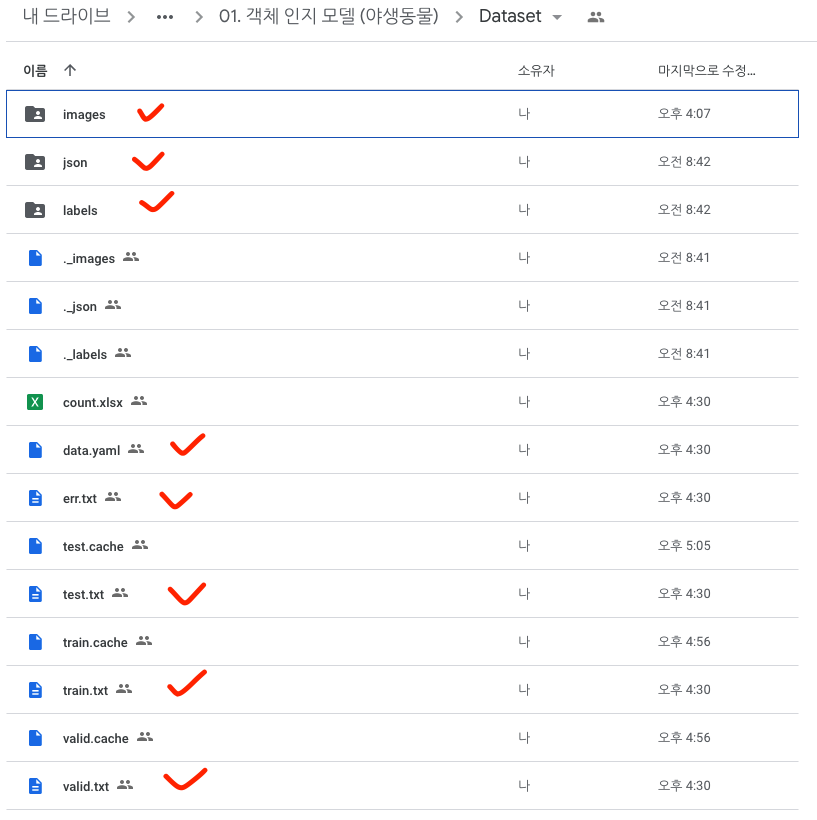

> 들여쓴 블록



In [ ]:
# yolo 및 yolo 실행에 필요한 모듈 설치
# 코랩 실행시
## 종혁 : yolo 버전 미일치로 새로운 yolo clone

import shutil
path = main_path
os.chdir(path)
!git clone https://github.com/ultralytics/yolov5.git
os.chdir(path + 'yolov5')
!pip3 install -r requirements.txt
print('완료')

Cloning into 'yolov5'...
remote: Enumerating objects: 15305, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 15305 (delta 0), reused 3 (delta 0), pack-reused 15300
Receiving objects: 100% (15305/15305), 14.19 MiB | 24.02 MiB/s, done.
Resolving deltas: 100% (10493/10493), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 6.0 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the follow

In [ ]:
# 괄호 왼쪽에 지정한 경로의 파일을, 괄호 오른쪽에 지정한 경로로 복사해줌.

import shutil
shutil.copy('/content/drive/MyDrive/[SeSAC] Final_PJT 공유폴더/03. 파이널_야생동물 객체 탐지, 추적 모델/코드/01. 객체 인지 모델 (야생동물)/yolov5/yolov5s.pt', '/content/train/Dataset')

'/content/train/Dataset/yolov5s.pt'

In [ ]:
# yolo 학습 코드 (약 120시간 실행) 
# 종혁 : 이미지 50개 돌리는 데 3~5분 소요 -> 3만개면 50~100시간......

start = time.time()

path = main_path
os.chdir(path + 'yolov5')
!sudo python3 train.py --img 416 --batch 64 --epochs 30 --data ../Dataset/data.yaml --cfg ./models/yolov5s.yaml --weights /content/train/Dataset/yolov5s.pt

end = time.time()
print(f'{end - start:.5f} sec')

train: weights=/content/train/Dataset/yolov5s.pt, cfg=./models/yolov5s.yaml, data=../Dataset/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=30, batch_size=64, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-120-g3e55763 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.

In [ ]:
# yolo 테스트 코드
# 본 코드 오류시, 아래 셀의 설명을 읽어주세요.

os.chdir(path + 'yolov5')
%pwd
!sudo python3 val.py --data ../Dataset/data.yaml --batch 128 --weights /content/train/yolov5/runs/train/exp/weights/best.pt --task test --img 416 --save-txt --save-conf

# 학습 시간 36분
# 학습이 완료되면 본 폴더의 ./runs/train/{학습명}/weights/best.pt 에 weight 파일이 저장된다.
# 테스트를 위해서는 아래 테스트 코드를 돌리거나
# detect.py 를 weight 값을 먹여 실행해보면 된다.

val: data=../Dataset/data.yaml, weights=['/content/train/yolov5/runs/train/exp/weights/best.pt'], batch_size=128, imgsz=416, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=True, save_hybrid=False, save_conf=True, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-120-g3e55763 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /content/train/Dataset/test... 15344 images, 0 backgrounds, 1 corrupt: 100% 15345/15345 [00:01<00:00, 7865.65it/s]
test: WARNING ⚠️ /content/train/Dataset/images/A02_H20_C012_C_211113_5061_20S_000019.045.jpg: 2 duplicate labels removed
test: WARNING ⚠️ /content/train/Dataset/images/A09_H09_C015_D_211007_0077_49S_000008.304.jpg: 1 duplicate labels removed
test: WARNING ⚠️ /content/train/Dataset/images/A09_


> **테스트 코드 오류시 참고**  

테스트 돌릴 때에는, best모델 경로 지정 잘 해줘야 함다.  
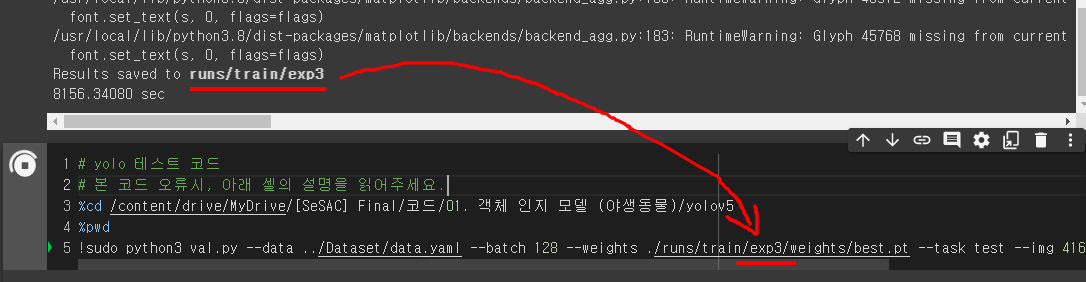

In [ ]:
# weight 파일 구글드라이브로 옮기기

import shutil

i = len(os.listdir(google_drive_path + 'yolov5/runs/train/'))
folder_name = google_drive_path + 'yolov5/runs/train/exp' + str(i + 1)
os.mkdir(folder_name)

origin = main_path + f'yolov5/runs/train/exp/weights/best.pt'
copy = folder_name + f'/best{i+1}.pt'
shutil.copy(origin, copy)

'/content/drive/MyDrive/[SeSAC] Final_PJT 공유폴더/03. 파이널_야생동물 객체 탐지, 추적 모델/코드/01. 객체 인지 모델 (야생동물)/yolov5/runs/train/exp5/best5.pt'

In [ ]:
# pt 파일에 학습된 레이블 값들 확인하는 코드

import torch

# Load the weights file
weights_file = '/content/drive/MyDrive/[SeSAC] Final_PJT 공유폴더/03. 파이널_야생동물 객체 탐지, 추적 모델/코드/01. 객체 인지 모델 (야생동물)/yolov5/runs/train/exp5/best5.pt'
model = torch.load(weights_file, map_location=torch.device('cpu'))['model'].float().eval()

# Print the label values
labels = model.names
print(labels)

{0: '족제비', 1: '멧돼지', 2: '너구리', 3: '고라니', 4: '반달가슴곰', 5: '노루', 6: '중대백로', 7: '왜가리', 8: '멧토끼', 9: '다람쥐'}
